In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.compat.v1 as tfc

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
sess = tfc.InteractiveSession()

## Adjust CSV

In [2]:
#adjust names to fit
train_csv = "train.csv"
train_df = pd.read_csv(train_csv)
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

species_labels = list(train_df.species.unique())
images = train_df['image']
sid = train_df['individual_id']
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


amount of species: 26


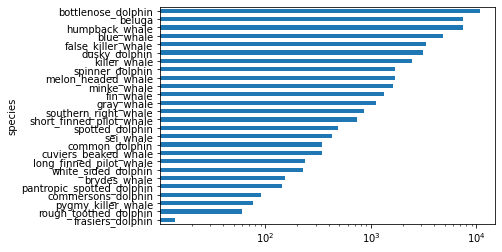

In [8]:
print(f"amount of species: {len(train_df.species.unique())}")
train_df.groupby(by='species').size().sort_values().plot.barh().set_xscale('log')

In [9]:
def get_id(sp):
    return species_labels.index(sp)
##encode species
train_df["species"] = train_df.apply(lambda row :get_id(row["species"]),axis = 1)

##one-hot encode species
#train_df = pd.concat([train_df, pd.get_dummies(train_df["species"],prefix='species_',drop_first=True)], axis = 1)
#train_df.drop(['species'],axis=1, inplace=True)
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,0,cadddb1636b9
1,000562241d384d.jpg,1,1a71fbb72250
2,0007c33415ce37.jpg,2,60008f293a2b
3,0007d9bca26a99.jpg,3,4b00fe572063
4,00087baf5cef7a.jpg,1,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,4,5ac053677ed1
51029,fff8b32daff17e.jpg,17,1184686361b3
51030,fff94675cc1aef.jpg,7,5401612696b9
51031,fffbc5dd642d8c.jpg,4,4000b3d7c24e


## Input Pipeline

In [10]:
IMG_SIZE = 64
BATCH_SIZE = 10
AMT_CLASSES = len(train_df.species.unique())

In [11]:
def process_img(img):
    img = tf.image.decode_jpeg(img, channels=3) 
    img = tf.image.convert_image_dtype(img, tf.float32) 
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='bilinear', preserve_aspect_ratio=False, antialias=False,) 
    img = tf.image.per_image_standardization(img)
    return img

def get_label(path):
    parts = tf.strings.split(path, "\\")
    file_name= parts[-1]
    label= train_df[train_df["image"]==file_name]["species"].to_numpy().squeeze()
    return tf.convert_to_tensor(label)

def process_path(path):
    img = process_img(tf.io.read_file(path))
    label = get_label(path)
    return img, label

In [12]:
full_img = list(map('train_images/'.__add__,images))

dataset = tf.data.Dataset.list_files('train_images/*')
dataset = dataset.map(lambda x: tf.py_function(process_path, [x], [tf.float32,tf.int64]),num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)

In [13]:
image_count = dataset.cardinality().numpy()
train_size = int(image_count*0.8)
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)


train_batched = train_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE) 
test_batched = test_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)

## Sequential Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               6291968   
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 26)                1690      
                                                                 
Total params: 6,466,138
Trainable params: 6,466,138
No

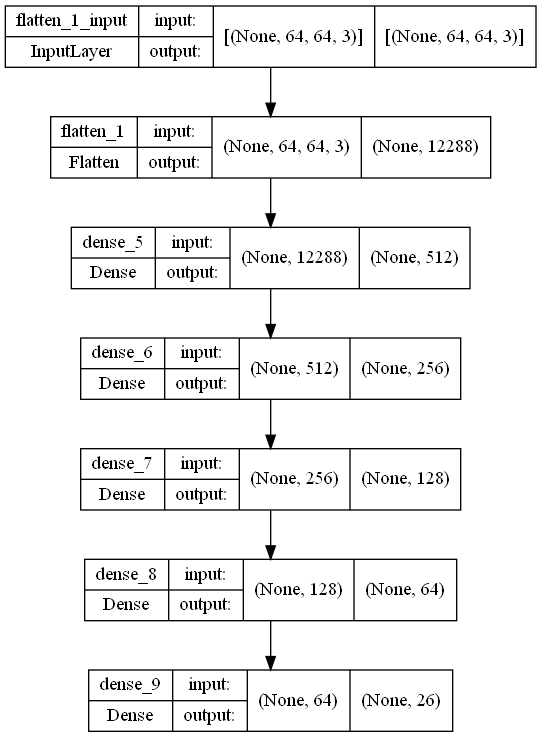

In [14]:
#generating model
model = keras.Sequential([
    layers.Flatten(input_shape=[64, 64, 3]),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(26, activation="softmax"),
])
model.summary()
plot_model(model,show_shapes=True, show_layer_names=True)

In [15]:
#compiling model
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.SGD(),                    
              metrics=[keras.metrics.SparseCategoricalAccuracy()]) 

In [ ]:
#model.fit(train_ds, epochs=1)

## CNN

In [16]:
def create_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    data_augmentation = keras.Sequential(
        [
            #version tf 2.4.1: 
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.1),
        ]
    )
    # Image augmentation block
    x = data_augmentation(inputs)
    activation_str = "elu"
    # Entry block
    #version tf 2.4.1
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    #-----------------
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation_str)(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation_str)(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation(activation_str)(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation(activation_str)(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation_str)(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 64, 64, 3)    0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 64, 64, 3)    0           ['sequential_2[0][0]']           
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['rescaling[0][0]']              
                                                                                              

 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 4, 4, 512)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_4 (Conv2D)              (None, 4, 4, 512)    131584      ['add_1[0][0]']                  
                                                                                                  
 add_2 (Add)                    (None, 4, 4, 512)    0           ['max_pooling2d_2[0][0]',        
                                                                  'conv2d_4[0][0]']               
                                                                                                  
 activation_8 (Activation)      (None, 4, 4, 512)    0           ['add_2[0][0]']                  
          

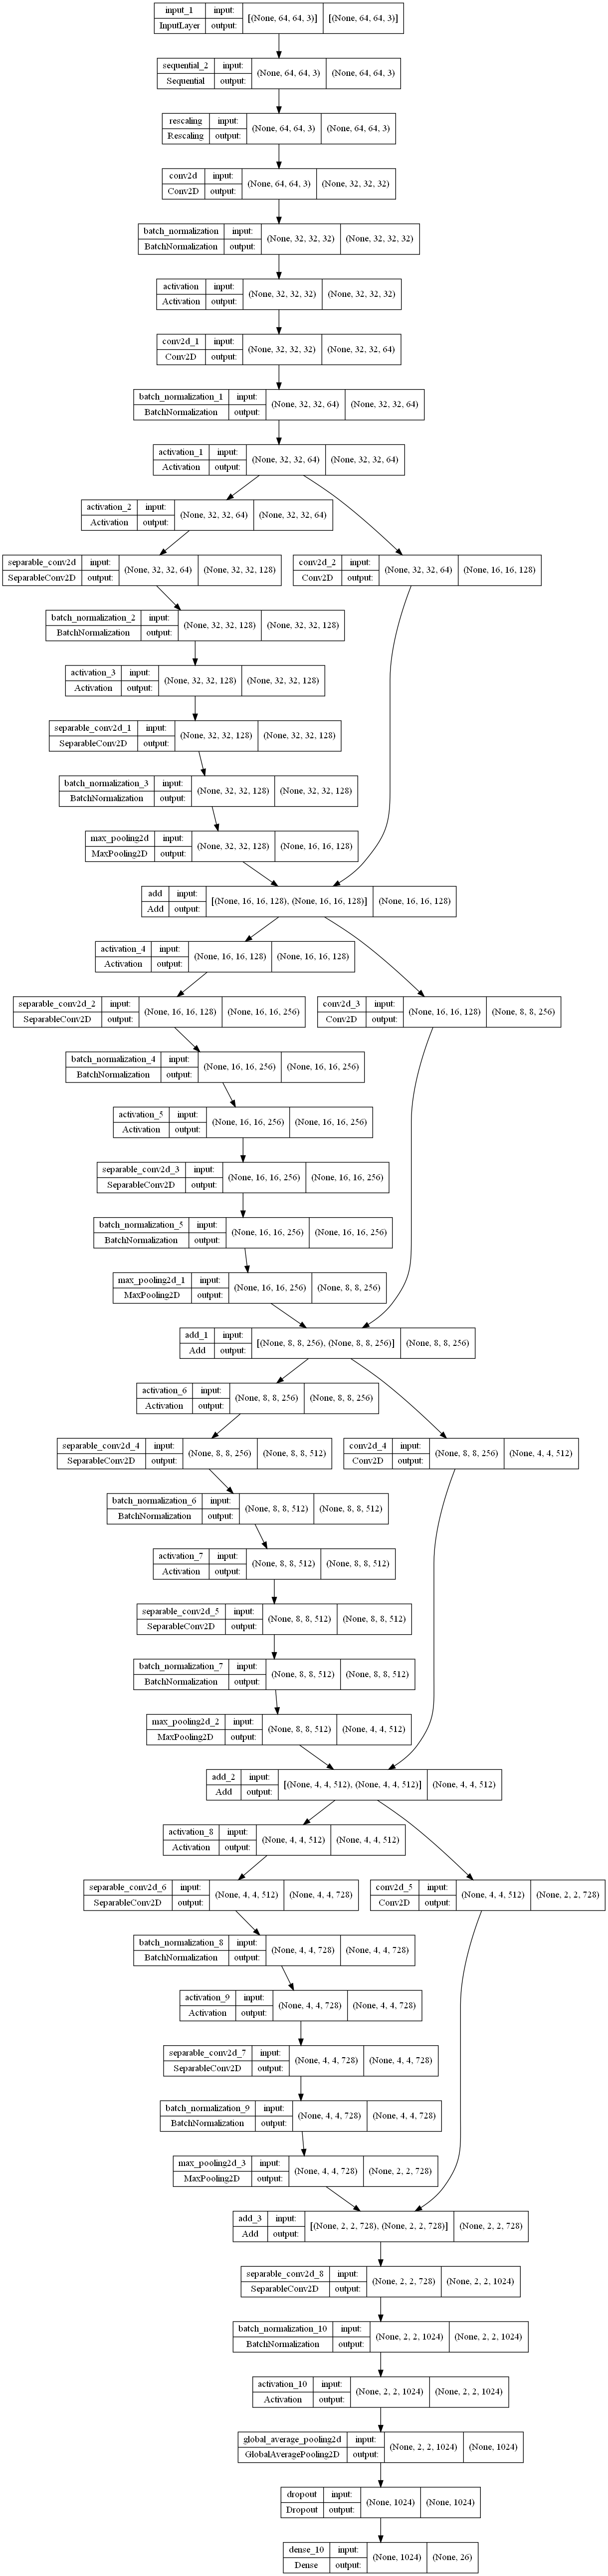

In [17]:
#creating model
cnnmodel = create_model([IMG_SIZE, IMG_SIZE, 3], AMT_CLASSES)
cnnmodel.summary()
plot_model(cnnmodel,show_shapes=True, show_layer_names=True)

In [20]:
#compiling model
cnnmodel.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.SGD(),                    
              metrics=[keras.metrics.SparseCategoricalAccuracy()]) 

In [ ]:
cnnmodel.fit(train_batched, epochs = 5)

Epoch 1/5
 141/4083 [>.............................] - ETA: 60:59:13 - loss: 2.2378 - sparse_categorical_accuracy: 0.4021

In [ ]:
cnnmodel.evaluate(test_batched)